In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse

from torchsummary import summary

import wandb

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
##Resnet Model

import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 1, 1, 1])

In [4]:
print(torch.cuda.is_available())

True


In [5]:
#model

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('==> Building model..')
net = ResNet18()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

==> Building model..


In [6]:
##Model Parameters

summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [7]:
#hyperparameters

lr = 0.1
num_workers = 2
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(net.parameters(), lr=lr, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [8]:
data_path = "./data"

best_acc = 0  # best test accuracy
best_train_acc = 0   #best train accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

epochs = 50

In [9]:
# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root=data_path, train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=num_workers)

testset = torchvision.datasets.CIFAR10(
    root=data_path, train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=num_workers)


classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [10]:
##Training

def train(epoch, optimizer, net, best_train_acc):
    # print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    if best_train_acc < 100.*correct/total:
        best_train_acc = 100.*correct/total
    
    return 100.*correct/total, train_loss/(batch_idx+1), best_train_acc

In [11]:
##Testing

def test(epoch, optimizer, net, best_acc, save_weights):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        if save_weights:
            print('Saving..')
            state = {
                'net': net.state_dict(),
                'acc': acc,
                'epoch': epoch,
            }
            if not os.path.isdir('checkpoint'):
                os.mkdir('checkpoint')
            torch.save(state, './checkpoint/ckpt.pth')
        
        best_acc = acc
        
    return 100.*correct/total, test_loss/(batch_idx+1), best_acc

In [12]:
##optimizers

optimizers = {'sgd': optim.SGD, 
            'adam': optim.Adam, 
            'sgd-nesterov': optim.SGD,
            'adagrad': optim.Adagrad,
            'adadelta': optim.Adadelta}

def optim_func(optimizer_, net, lr=0.1, momentum=0.9, weight_decay=5e-4):
  if optimizer_ == 'sgd':
      optimizer = optimizers[optimizer_](net.parameters(), lr=lr,
                    momentum=momentum, weight_decay=weight_decay)

  elif optimizer_ == 'sgd-nesterov':
      optimizer = optimizers[optimizer_](net.parameters(), lr=lr,
                    momentum=momentum, weight_decay=weight_decay, nesterov=True)

  else:
      optimizer = optimizers[optimizer_](net.parameters(), lr=lr, weight_decay=weight_decay)

  return optimizer

In [24]:
##Main

def main(optimizer_, epochs, lr, momentum, weight_decay, save_weights, ret_polt_values):
   
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    net = ResNet18()
    net = net.to(device)
    if device == 'cuda':
        net = torch.nn.DataParallel(net)
        cudnn.benchmark = True
        
    best_train_acc = 0
    best_acc = 0
    train_accs = []
    test_accs= []
    for epoch in range(start_epoch, start_epoch + epochs):
        
        optimizer = optim_func(optimizer_, net, lr, momentum, weight_decay)

        print(f"Running Epoch {epoch}...")
        train_acc, train_loss, best_train_acc = train(epoch, optimizer, net, best_train_acc)
        test_acc, test_loss, best_acc = test(epoch, optimizer, net, best_acc, save_weights)
        scheduler.step()

        print("Train==>", "Loss:", format(train_loss, '.03f'), 'Acc:', format(train_acc, '.03f'))
        print("Test==>", "Loss:", format(test_loss, '.03f'), 'Acc:', format(test_acc, '.03f'))
        
        if wandb.run is not None:
            wandb.log(
                {
                    "train_loss": train_loss,
                    "train_accuracy": train_acc,
                    "test_loss": test_loss,
                    "test_accuracy": test_acc,
                    "epoch": epoch + 1,
                }
            )
            
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        
    print("\n\nBest accuracy:", best_acc)
    
    if ret_polt_values:
        return train_accs, test_accs

In [14]:
##Running sweep to determin best hyperparameters

metric_config = {
    "name": "train_accuracy",
    "goal": "maximize",
}

parameters_config = {
    "optimizer": {
        "values": ['sgd', 
                   'adam', 
                   'sgd-nesterov',
                   'adagrad',
                   'adadelta'],
    },
    "learning_rate": {"values": [0.01, 0.1]},
    "weight_decay": {"values": [0.0005, 0.001]},
    "momentum": {"values": [0.9, 0.99]},
}

sweep_config = {
    "method": "random",
    "metric": metric_config,
    "parameters": parameters_config,
}

import pprint

pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'maximize', 'name': 'train_accuracy'},
 'parameters': {'learning_rate': {'values': [0.01, 0.1]},
                'momentum': {'values': [0.9, 0.99]},
                'optimizer': {'values': ['sgd',
                                         'adam',
                                         'sgd-nesterov',
                                         'adagrad',
                                         'adadelta']},
                'weight_decay': {'values': [0.0005, 0.001]}}}


In [15]:
wandb.login()

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\hnnha/.netrc


In [16]:
sweep_id = wandb.sweep(sweep_config, project="dl_mini")

# sweep_id = 'ywo62d4s'

Create sweep with ID: ct9ebkvi
Sweep URL: https://wandb.ai/hn2237/dl_mini/sweeps/ct9ebkvi


In [17]:
##test runs with wandb

def test_wandb(config=None):
     with wandb.init(config=config):
        config = wandb.config

        main(optimizer_ = config.optimizer, 
             epochs = 20, 
             lr = config.learning_rate, 
             momentum = config.momentum, 
             weight_decay = config.weight_decay,
             save_weights = False,
             ret_polt_values = False)

In [18]:
wandb.agent(sweep_id, test_wandb, count=20)

wandb: Agent Starting Run: z68nwuvp with config:
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.9
wandb: 	optimizer: adagrad
wandb: 	weight_decay: 0.0005
wandb: Currently logged in as: hn2237. Use `wandb login --relogin` to force relogin


Running Epoch 0...


c:\users\hnnha\appdata\local\programs\python\python37\lib\site-packages\torch\optim\lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train==> Loss: 1.602 Acc: 40.678
Test==> Loss: 1.332 Acc: 52.580
Running Epoch 1...
Train==> Loss: 1.424 Acc: 47.728
Test==> Loss: 1.223 Acc: 55.290
Running Epoch 2...
Train==> Loss: 1.343 Acc: 51.116
Test==> Loss: 1.237 Acc: 56.090
Running Epoch 3...
Train==> Loss: 1.219 Acc: 55.798
Test==> Loss: 1.082 Acc: 61.030
Running Epoch 4...
Train==> Loss: 1.205 Acc: 56.534
Test==> Loss: 1.299 Acc: 55.260
Running Epoch 5...
Train==> Loss: 1.134 Acc: 59.164
Test==> Loss: 1.089 Acc: 62.110
Running Epoch 6...
Train==> Loss: 1.064 Acc: 61.752
Test==> Loss: 0.913 Acc: 67.270
Running Epoch 7...
Train==> Loss: 1.017 Acc: 63.700
Test==> Loss: 0.894 Acc: 68.080
Running Epoch 8...
Train==> Loss: 1.004 Acc: 64.134
Test==> Loss: 1.503 Acc: 57.160
Running Epoch 9...
Train==> Loss: 0.900 Acc: 68.218
Test==> Loss: 0.789 Acc: 72.250
Running Epoch 10...
Train==> Loss: 0.855 Acc: 69.832
Test==> Loss: 0.801 Acc: 72.210
Running Epoch 11...
Train==> Loss: 0.786 Acc: 72.472
Test==> Loss: 0.744 Acc: 74.590
Running E

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁▂▂▃▂▃▄▅▂▆▆▆▅▆▆▇▇▇▇█
test_loss,▇▆▆▅▇▅▄▄█▃▃▃▄▂▃▂▂▂▂▁
train_accuracy,▁▂▃▄▄▄▅▅▅▆▆▆▇▇▇▇████
train_loss,█▇▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁
epoch,20
test_accuracy,83.01
test_loss,0.51719
train_accuracy,81.672
train_loss,0.53929


wandb: Agent Starting Run: w2keohtb with config:
wandb: 	learning_rate: 0.1
wandb: 	momentum: 0.9
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Running Epoch 0...
Train==> Loss: 2.155 Acc: 22.808
Test==> Loss: 2.708 Acc: 15.360
Running Epoch 1...
Train==> Loss: 1.831 Acc: 29.982
Test==> Loss: 1.917 Acc: 29.630
Running Epoch 2...
Train==> Loss: 1.765 Acc: 33.720
Test==> Loss: 2.058 Acc: 24.080
Running Epoch 3...
Train==> Loss: 1.734 Acc: 34.554
Test==> Loss: 1.852 Acc: 30.890
Running Epoch 4...
Train==> Loss: 1.745 Acc: 34.330
Test==> Loss: 2.214 Acc: 24.870
Running Epoch 5...
Train==> Loss: 1.721 Acc: 35.706
Test==> Loss: 2.558 Acc: 19.350
Running Epoch 6...
Train==> Loss: 1.683 Acc: 36.924
Test==> Loss: 2.425 Acc: 25.810
Running Epoch 7...
Train==> Loss: 1.679 Acc: 36.660
Test==> Loss: 3.339 Acc: 19.150
Running Epoch 8...
Train==> Loss: 1.687 Acc: 37.384
Test==> Loss: 2.310 Acc: 23.310
Running Epoch 9...
Train==> Loss: 1.669 Acc: 37.926
Test==> Loss: 2.568 Acc: 25.450
Running Epoch 10...
Train==> Loss: 1.646 Acc: 38.508
Test==> Loss: 3.043 Acc: 23.200
Running Epoch 11...
Train==> Loss: 1.650 Acc: 38.678
Test==> Loss: 4.051 Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▃█▆█▆▄▆▄▅▆▅▁▇▃▂▂▃▄▃▄
test_loss,▂▁▁▁▁▂▁▂▁▂▂▃▁▂█▄▄▂▅▃
train_accuracy,▁▄▆▆▆▆▇▇▇▇███▇██▇███
train_loss,█▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁
epoch,20
test_accuracy,19.03
test_loss,4.16762
train_accuracy,39.608
train_loss,1.61697


wandb: Agent Starting Run: qhl6cxpx with config:
wandb: 	learning_rate: 0.1
wandb: 	momentum: 0.99
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005


Running Epoch 0...
Train==> Loss: 2.162 Acc: 22.912
Test==> Loss: 3.848 Acc: 24.490
Running Epoch 1...
Train==> Loss: 1.817 Acc: 31.226
Test==> Loss: 2.780 Acc: 18.970
Running Epoch 2...
Train==> Loss: 1.758 Acc: 33.940
Test==> Loss: 2.264 Acc: 26.210
Running Epoch 3...
Train==> Loss: 1.737 Acc: 34.988
Test==> Loss: 3.961 Acc: 16.490
Running Epoch 4...
Train==> Loss: 1.725 Acc: 35.722
Test==> Loss: 2.219 Acc: 24.340
Running Epoch 5...
Train==> Loss: 1.715 Acc: 35.856
Test==> Loss: 2.439 Acc: 24.570
Running Epoch 6...
Train==> Loss: 1.692 Acc: 37.056
Test==> Loss: 2.464 Acc: 29.900
Running Epoch 7...
Train==> Loss: 1.689 Acc: 36.962
Test==> Loss: 2.781 Acc: 18.380
Running Epoch 8...
Train==> Loss: 1.699 Acc: 36.552
Test==> Loss: 8.840 Acc: 10.110
Running Epoch 9...
Train==> Loss: 1.700 Acc: 36.992
Test==> Loss: 6.954 Acc: 13.560
Running Epoch 10...
Train==> Loss: 1.668 Acc: 38.168
Test==> Loss: 2.135 Acc: 25.260
Running Epoch 11...
Train==> Loss: 1.657 Acc: 38.620
Test==> Loss: 5.252 Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▆▄▇▃▆▆█▄▁▂▆▂▃▅▂▄▇▁▁▆
test_loss,▂▁▁▂▁▁▁▁▆▄▁▃▄▂▄▃▁▅█▂
train_accuracy,▁▅▆▆▇▇▇▇▇▇████▇█████
train_loss,█▃▃▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁
epoch,20
test_accuracy,23.3
test_loss,3.96662
train_accuracy,38.892
train_loss,1.6336


wandb: Agent Starting Run: fvcujixt with config:
wandb: 	learning_rate: 0.1
wandb: 	momentum: 0.99
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005


Running Epoch 0...
Train==> Loss: 1.861 Acc: 30.692
Test==> Loss: 1.728 Acc: 33.940
Running Epoch 1...
Train==> Loss: 1.544 Acc: 42.764
Test==> Loss: 1.520 Acc: 45.910
Running Epoch 2...
Train==> Loss: 1.376 Acc: 50.046
Test==> Loss: 1.541 Acc: 46.510
Running Epoch 3...
Train==> Loss: 1.275 Acc: 54.468
Test==> Loss: 1.448 Acc: 50.030
Running Epoch 4...
Train==> Loss: 1.242 Acc: 55.936
Test==> Loss: 1.383 Acc: 52.130
Running Epoch 5...
Train==> Loss: 1.187 Acc: 57.856
Test==> Loss: 2.278 Acc: 39.770
Running Epoch 6...
Train==> Loss: 1.152 Acc: 59.012
Test==> Loss: 1.824 Acc: 46.580
Running Epoch 7...
Train==> Loss: 1.120 Acc: 60.724
Test==> Loss: 1.728 Acc: 49.600
Running Epoch 8...
Train==> Loss: 1.053 Acc: 63.480
Test==> Loss: 1.299 Acc: 56.960
Running Epoch 9...
Train==> Loss: 1.065 Acc: 62.792
Test==> Loss: 1.198 Acc: 58.820
Running Epoch 10...
Train==> Loss: 1.040 Acc: 63.874
Test==> Loss: 1.458 Acc: 53.360
Running Epoch 11...
Train==> Loss: 1.074 Acc: 62.648
Test==> Loss: 1.880 Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁▄▄▅▆▂▄▅▇▇▆▄▄▅▄█▅▅▂▆
test_loss,▄▃▃▃▂▇▅▄▂▁▃▅▅▃▄▁▄▄█▃
train_accuracy,▁▄▅▆▆▇▇▇████████████
train_loss,█▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
test_accuracy,54.45
test_loss,1.56277
train_accuracy,62.194
train_loss,1.07944


wandb: Agent Starting Run: qnetl69f with config:
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.99
wandb: 	optimizer: adadelta
wandb: 	weight_decay: 0.001


Running Epoch 0...
Train==> Loss: 1.761 Acc: 35.404
Test==> Loss: 1.509 Acc: 44.340
Running Epoch 1...
Train==> Loss: 1.449 Acc: 47.474
Test==> Loss: 1.361 Acc: 50.250
Running Epoch 2...
Train==> Loss: 1.303 Acc: 53.172
Test==> Loss: 1.234 Acc: 55.440
Running Epoch 3...
Train==> Loss: 1.203 Acc: 57.218
Test==> Loss: 1.186 Acc: 57.650
Running Epoch 4...
Train==> Loss: 1.126 Acc: 59.856
Test==> Loss: 1.101 Acc: 60.370
Running Epoch 5...
Train==> Loss: 1.059 Acc: 62.756
Test==> Loss: 1.098 Acc: 61.180
Running Epoch 6...
Train==> Loss: 1.006 Acc: 64.528
Test==> Loss: 0.996 Acc: 64.860
Running Epoch 7...
Train==> Loss: 0.963 Acc: 66.254
Test==> Loss: 0.968 Acc: 65.250
Running Epoch 8...
Train==> Loss: 0.919 Acc: 67.884
Test==> Loss: 0.939 Acc: 66.560
Running Epoch 9...
Train==> Loss: 0.884 Acc: 68.998
Test==> Loss: 0.916 Acc: 68.070
Running Epoch 10...
Train==> Loss: 0.850 Acc: 70.260
Test==> Loss: 1.046 Acc: 64.210
Running Epoch 11...
Train==> Loss: 0.817 Acc: 71.384
Test==> Loss: 1.011 Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁▂▄▄▅▅▆▆▆▆▅▆▇▇▇▇█▇██
test_loss,█▇▆▅▄▄▃▃▃▃▄▄▂▂▂▂▁▂▁▁
train_accuracy,▁▃▄▅▅▅▆▆▆▆▇▇▇▇▇█████
train_loss,█▆▅▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁
epoch,20
test_accuracy,75.17
test_loss,0.72111
train_accuracy,78.208
train_loss,0.62875


wandb: Agent Starting Run: qj16d1j2 with config:
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.9
wandb: 	optimizer: adagrad
wandb: 	weight_decay: 0.001


Running Epoch 0...
Train==> Loss: 1.593 Acc: 40.740
Test==> Loss: 1.386 Acc: 48.660
Running Epoch 1...
Train==> Loss: 1.470 Acc: 45.586
Test==> Loss: 1.168 Acc: 57.700
Running Epoch 2...
Train==> Loss: 1.422 Acc: 47.136
Test==> Loss: 1.313 Acc: 53.160
Running Epoch 3...
Train==> Loss: 1.381 Acc: 49.102
Test==> Loss: 1.173 Acc: 57.360
Running Epoch 4...
Train==> Loss: 1.354 Acc: 50.510
Test==> Loss: 1.411 Acc: 52.450
Running Epoch 5...
Train==> Loss: 1.277 Acc: 53.240
Test==> Loss: 1.109 Acc: 60.420
Running Epoch 6...
Train==> Loss: 1.210 Acc: 56.038
Test==> Loss: 1.337 Acc: 52.830
Running Epoch 7...
Train==> Loss: 1.122 Acc: 59.534
Test==> Loss: 0.977 Acc: 65.610
Running Epoch 8...
Train==> Loss: 1.037 Acc: 62.928
Test==> Loss: 0.913 Acc: 67.170
Running Epoch 9...
Train==> Loss: 0.980 Acc: 65.046
Test==> Loss: 1.029 Acc: 64.930
Running Epoch 10...
Train==> Loss: 0.915 Acc: 67.766
Test==> Loss: 0.816 Acc: 71.440
Running Epoch 11...
Train==> Loss: 0.866 Acc: 69.474
Test==> Loss: 0.937 Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁▃▂▃▂▄▂▅▅▅▆▅▇▇▇▇▇██▆
test_loss,█▆▇▆█▅▇▄▄▅▃▄▂▂▂▁▃▁▁▄
train_accuracy,▁▂▂▃▃▃▄▄▅▅▆▆▇▇▇▇████
train_loss,█▇▇▇▆▆▅▅▄▄▃▃▂▂▂▂▁▁▁▁
epoch,20
test_accuracy,72.48
test_loss,0.93216
train_accuracy,79.724
train_loss,0.59329


wandb: Agent Starting Run: tn9wmiuw with config:
wandb: 	learning_rate: 0.1
wandb: 	momentum: 0.9
wandb: 	optimizer: sgd-nesterov
wandb: 	weight_decay: 0.0005


Running Epoch 0...
Train==> Loss: 1.554 Acc: 42.806
Test==> Loss: 1.237 Acc: 56.170
Running Epoch 1...
Train==> Loss: 1.038 Acc: 62.908
Test==> Loss: 1.109 Acc: 63.220
Running Epoch 2...
Train==> Loss: 0.850 Acc: 69.912
Test==> Loss: 0.891 Acc: 70.000
Running Epoch 3...
Train==> Loss: 0.721 Acc: 74.822
Test==> Loss: 0.703 Acc: 75.400
Running Epoch 4...
Train==> Loss: 0.619 Acc: 78.484
Test==> Loss: 0.740 Acc: 75.730
Running Epoch 5...
Train==> Loss: 0.561 Acc: 80.614
Test==> Loss: 0.678 Acc: 76.460
Running Epoch 6...
Train==> Loss: 0.520 Acc: 82.030
Test==> Loss: 0.678 Acc: 77.260
Running Epoch 7...
Train==> Loss: 0.489 Acc: 83.200
Test==> Loss: 0.570 Acc: 79.980
Running Epoch 8...
Train==> Loss: 0.469 Acc: 83.788
Test==> Loss: 0.755 Acc: 76.430
Running Epoch 9...
Train==> Loss: 0.452 Acc: 84.406
Test==> Loss: 0.850 Acc: 74.350
Running Epoch 10...
Train==> Loss: 0.439 Acc: 84.780
Test==> Loss: 0.713 Acc: 76.180
Running Epoch 11...
Train==> Loss: 0.422 Acc: 85.578
Test==> Loss: 0.918 Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁▃▄▅▆▆▆▇▆▅▆▅▆▇▇▆▇▇▆█
test_loss,█▇▅▃▄▃▃▂▄▅▄▅▃▃▂▃▂▂▅▁
train_accuracy,▁▄▅▆▇▇▇▇▇███████████
train_loss,█▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,20
test_accuracy,86.19
test_loss,0.4156
train_accuracy,87.396
train_loss,0.36683


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ldyx17l8 with config:
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.99
wandb: 	optimizer: sgd-nesterov
wandb: 	weight_decay: 0.001


Running Epoch 0...
Train==> Loss: 1.458 Acc: 46.556
Test==> Loss: 1.496 Acc: 50.410
Running Epoch 1...
Train==> Loss: 1.048 Acc: 62.662
Test==> Loss: 1.000 Acc: 63.810
Running Epoch 2...
Train==> Loss: 0.871 Acc: 69.054
Test==> Loss: 1.031 Acc: 64.710
Running Epoch 3...
Train==> Loss: 0.746 Acc: 73.938
Test==> Loss: 0.892 Acc: 69.500
Running Epoch 4...
Train==> Loss: 0.670 Acc: 76.808
Test==> Loss: 0.726 Acc: 74.450
Running Epoch 5...
Train==> Loss: 0.618 Acc: 78.716
Test==> Loss: 0.772 Acc: 74.940
Running Epoch 6...
Train==> Loss: 0.587 Acc: 79.970
Test==> Loss: 0.666 Acc: 77.860
Running Epoch 7...
Train==> Loss: 0.552 Acc: 80.934
Test==> Loss: 0.651 Acc: 78.420
Running Epoch 8...
Train==> Loss: 0.542 Acc: 81.358
Test==> Loss: 0.734 Acc: 75.780
Running Epoch 9...
Train==> Loss: 0.524 Acc: 82.158
Test==> Loss: 0.600 Acc: 79.590
Running Epoch 10...
Train==> Loss: 0.517 Acc: 82.116
Test==> Loss: 0.705 Acc: 76.560
Running Epoch 11...
Train==> Loss: 0.507 Acc: 82.620
Test==> Loss: 0.671 Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁▄▄▆▇▇██▇█▇██▇█▇▇███
test_loss,█▄▄▃▂▂▂▁▂▁▂▂▁▃▁▂▂▁▂▁
train_accuracy,▁▄▅▆▇▇▇▇████████████
train_loss,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
test_accuracy,78.17
test_loss,0.64191
train_accuracy,83.722
train_loss,0.47668


wandb: Agent Starting Run: qrf0frtf with config:
wandb: 	learning_rate: 0.1
wandb: 	momentum: 0.99
wandb: 	optimizer: sgd-nesterov
wandb: 	weight_decay: 0.0005


Running Epoch 0...
Train==> Loss: 2.043 Acc: 24.478
Test==> Loss: 1.986 Acc: 22.980
Running Epoch 1...
Train==> Loss: 1.561 Acc: 42.448
Test==> Loss: 1.531 Acc: 45.910
Running Epoch 2...
Train==> Loss: 1.269 Acc: 54.512
Test==> Loss: 1.233 Acc: 56.490
Running Epoch 3...
Train==> Loss: 1.119 Acc: 60.108
Test==> Loss: 1.159 Acc: 58.970
Running Epoch 4...
Train==> Loss: 1.024 Acc: 63.936
Test==> Loss: 1.485 Acc: 54.130
Running Epoch 5...
Train==> Loss: 0.964 Acc: 66.228
Test==> Loss: 1.632 Acc: 51.230
Running Epoch 6...
Train==> Loss: 0.930 Acc: 67.620
Test==> Loss: 1.588 Acc: 52.580
Running Epoch 7...
Train==> Loss: 0.924 Acc: 67.816
Test==> Loss: 1.461 Acc: 57.140
Running Epoch 8...
Train==> Loss: 0.916 Acc: 68.134
Test==> Loss: 1.379 Acc: 56.490
Running Epoch 9...
Train==> Loss: 0.909 Acc: 68.410
Test==> Loss: 1.103 Acc: 62.220
Running Epoch 10...
Train==> Loss: 0.896 Acc: 68.860
Test==> Loss: 0.910 Acc: 68.110
Running Epoch 11...
Train==> Loss: 0.904 Acc: 68.396
Test==> Loss: 1.545 Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁▅▆▇▆▅▆▆▆▇█▆▇▇▆▅▅▇▆▆
test_loss,█▅▃▃▅▆▅▄▄▂▁▅▂▃▄█▆▃▄▄
train_accuracy,▁▄▆▇▇███████████████
train_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
test_accuracy,54.95
test_loss,1.45222
train_accuracy,68.258
train_loss,0.91202


wandb: Agent Starting Run: i9x69au7 with config:
wandb: 	learning_rate: 0.1
wandb: 	momentum: 0.99
wandb: 	optimizer: adadelta
wandb: 	weight_decay: 0.001


Running Epoch 0...
Train==> Loss: 1.408 Acc: 48.710
Test==> Loss: 1.248 Acc: 55.750
Running Epoch 1...
Train==> Loss: 0.967 Acc: 65.538
Test==> Loss: 1.095 Acc: 64.110
Running Epoch 2...
Train==> Loss: 0.792 Acc: 72.404
Test==> Loss: 0.807 Acc: 71.740
Running Epoch 3...
Train==> Loss: 0.668 Acc: 76.818
Test==> Loss: 0.738 Acc: 74.650
Running Epoch 4...
Train==> Loss: 0.589 Acc: 79.536
Test==> Loss: 0.752 Acc: 75.290
Running Epoch 5...
Train==> Loss: 0.529 Acc: 81.684
Test==> Loss: 0.635 Acc: 77.700
Running Epoch 6...
Train==> Loss: 0.487 Acc: 82.994
Test==> Loss: 0.564 Acc: 80.290
Running Epoch 7...
Train==> Loss: 0.448 Acc: 84.534
Test==> Loss: 0.734 Acc: 77.490
Running Epoch 8...
Train==> Loss: 0.421 Acc: 85.506
Test==> Loss: 0.584 Acc: 80.770
Running Epoch 9...
Train==> Loss: 0.396 Acc: 86.424
Test==> Loss: 0.566 Acc: 81.290
Running Epoch 10...
Train==> Loss: 0.370 Acc: 87.126
Test==> Loss: 0.492 Acc: 83.640
Running Epoch 11...
Train==> Loss: 0.351 Acc: 87.930
Test==> Loss: 0.528 Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁▃▅▅▅▆▆▆▇▇▇▇▆▇▇▇█▇█▇
test_loss,█▇▄▄▄▃▂▄▃▂▂▂▃▂▂▂▂▂▁▂
train_accuracy,▁▄▅▆▆▆▇▇▇▇▇▇▇███████
train_loss,█▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch,20
test_accuracy,85.12
test_loss,0.48133
train_accuracy,91.766
train_loss,0.2397


wandb: Agent Starting Run: pcmowcac with config:
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.9
wandb: 	optimizer: adadelta
wandb: 	weight_decay: 0.0005


Running Epoch 0...
Train==> Loss: 1.767 Acc: 35.500
Test==> Loss: 1.488 Acc: 45.370
Running Epoch 1...
Train==> Loss: 1.438 Acc: 47.926
Test==> Loss: 1.350 Acc: 50.580
Running Epoch 2...
Train==> Loss: 1.292 Acc: 53.336
Test==> Loss: 1.244 Acc: 54.470
Running Epoch 3...
Train==> Loss: 1.193 Acc: 57.366
Test==> Loss: 1.151 Acc: 58.900
Running Epoch 4...
Train==> Loss: 1.117 Acc: 59.968
Test==> Loss: 1.124 Acc: 59.780
Running Epoch 5...
Train==> Loss: 1.058 Acc: 62.338
Test==> Loss: 1.039 Acc: 62.510
Running Epoch 6...
Train==> Loss: 1.007 Acc: 64.354
Test==> Loss: 1.034 Acc: 62.920
Running Epoch 7...
Train==> Loss: 0.960 Acc: 65.968
Test==> Loss: 0.975 Acc: 65.480
Running Epoch 8...
Train==> Loss: 0.921 Acc: 67.326
Test==> Loss: 0.953 Acc: 65.750
Running Epoch 9...
Train==> Loss: 0.885 Acc: 68.744
Test==> Loss: 0.917 Acc: 67.570
Running Epoch 10...
Train==> Loss: 0.855 Acc: 69.878
Test==> Loss: 0.910 Acc: 68.190
Running Epoch 11...
Train==> Loss: 0.823 Acc: 71.032
Test==> Loss: 0.867 Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁▂▃▄▄▅▅▆▆▆▆▇▆▇▇▇█▇██
test_loss,█▇▆▅▅▄▄▃▃▃▃▂▃▂▂▂▂▂▁▁
train_accuracy,▁▃▄▅▅▅▆▆▆▇▇▇▇▇▇▇████
train_loss,█▆▅▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁
epoch,20
test_accuracy,74.94
test_loss,0.72249
train_accuracy,77.796
train_loss,0.64565


wandb: Agent Starting Run: wqn3k62d with config:
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.9
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


Running Epoch 0...
Train==> Loss: 1.781 Acc: 33.470
Test==> Loss: 1.658 Acc: 38.520
Running Epoch 1...
Train==> Loss: 1.351 Acc: 50.468
Test==> Loss: 1.746 Acc: 39.620
Running Epoch 2...
Train==> Loss: 1.132 Acc: 59.200
Test==> Loss: 1.321 Acc: 52.580
Running Epoch 3...
Train==> Loss: 1.056 Acc: 62.028
Test==> Loss: 1.789 Acc: 47.570
Running Epoch 4...
Train==> Loss: 0.995 Acc: 64.368
Test==> Loss: 1.168 Acc: 59.870
Running Epoch 5...
Train==> Loss: 0.955 Acc: 65.686
Test==> Loss: 1.103 Acc: 61.790
Running Epoch 6...
Train==> Loss: 0.916 Acc: 67.434
Test==> Loss: 1.072 Acc: 63.670
Running Epoch 7...
Train==> Loss: 0.885 Acc: 68.654
Test==> Loss: 0.883 Acc: 68.590
Running Epoch 8...
Train==> Loss: 0.868 Acc: 69.634
Test==> Loss: 0.978 Acc: 65.670
Running Epoch 9...
Train==> Loss: 0.846 Acc: 70.286
Test==> Loss: 1.168 Acc: 60.380
Running Epoch 10...
Train==> Loss: 0.837 Acc: 70.814
Test==> Loss: 1.287 Acc: 62.270
Running Epoch 11...
Train==> Loss: 0.822 Acc: 71.166
Test==> Loss: 1.539 Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁▁▄▃▆▆▇█▇▆▇▄▇▇▆▅▅▄▅▇
test_loss,▇█▄█▃▃▂▁▂▃▄▆▃▃▃▄▅▆▆▂
train_accuracy,▁▄▆▆▇▇▇▇▇███████████
train_loss,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch,20
test_accuracy,65.9
test_loss,1.01701
train_accuracy,72.654
train_loss,0.7873


wandb: Agent Starting Run: axuit4lc with config:
wandb: 	learning_rate: 0.1
wandb: 	momentum: 0.9
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.001


Running Epoch 0...
Train==> Loss: 1.602 Acc: 40.948
Test==> Loss: 1.452 Acc: 48.140
Running Epoch 1...
Train==> Loss: 1.134 Acc: 59.152
Test==> Loss: 1.216 Acc: 58.480
Running Epoch 2...
Train==> Loss: 0.923 Acc: 67.038
Test==> Loss: 1.011 Acc: 64.550
Running Epoch 3...
Train==> Loss: 0.779 Acc: 72.818
Test==> Loss: 1.125 Acc: 64.490
Running Epoch 4...
Train==> Loss: 0.698 Acc: 75.726
Test==> Loss: 0.792 Acc: 72.320
Running Epoch 5...
Train==> Loss: 0.653 Acc: 77.260
Test==> Loss: 1.207 Acc: 64.210
Running Epoch 6...
Train==> Loss: 0.619 Acc: 78.624
Test==> Loss: 0.724 Acc: 76.590
Running Epoch 7...
Train==> Loss: 0.594 Acc: 79.524
Test==> Loss: 1.185 Acc: 66.130
Running Epoch 8...
Train==> Loss: 0.578 Acc: 80.094
Test==> Loss: 0.981 Acc: 70.560
Running Epoch 9...
Train==> Loss: 0.564 Acc: 80.754
Test==> Loss: 0.956 Acc: 70.040
Running Epoch 10...
Train==> Loss: 0.553 Acc: 81.110
Test==> Loss: 0.977 Acc: 67.600
Running Epoch 11...
Train==> Loss: 0.546 Acc: 81.116
Test==> Loss: 1.013 Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁▃▅▅▇▅█▅▆▆▆▆▇█▅▇█▇█▆
test_loss,█▆▄▅▂▆▂▆▄▄▄▄▂▁▅▂▁▂▁▄
train_accuracy,▁▄▅▆▇▇▇▇████████████
train_loss,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
test_accuracy,69.15
test_loss,0.95016
train_accuracy,82.406
train_loss,0.51543


wandb: Agent Starting Run: hklbpx2g with config:
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.99
wandb: 	optimizer: adadelta
wandb: 	weight_decay: 0.0005


Running Epoch 0...
Train==> Loss: 1.769 Acc: 35.696
Test==> Loss: 1.511 Acc: 43.860
Running Epoch 1...
Train==> Loss: 1.442 Acc: 47.696
Test==> Loss: 1.396 Acc: 49.010
Running Epoch 2...
Train==> Loss: 1.301 Acc: 53.128
Test==> Loss: 1.226 Acc: 55.730
Running Epoch 3...
Train==> Loss: 1.203 Acc: 56.786
Test==> Loss: 1.247 Acc: 55.040
Running Epoch 4...
Train==> Loss: 1.129 Acc: 59.676
Test==> Loss: 1.089 Acc: 61.410
Running Epoch 5...
Train==> Loss: 1.065 Acc: 62.172
Test==> Loss: 1.134 Acc: 59.570
Running Epoch 6...
Train==> Loss: 1.009 Acc: 64.194
Test==> Loss: 0.988 Acc: 65.110
Running Epoch 7...
Train==> Loss: 0.964 Acc: 65.860
Test==> Loss: 0.976 Acc: 65.920
Running Epoch 8...
Train==> Loss: 0.923 Acc: 67.494
Test==> Loss: 0.987 Acc: 65.200
Running Epoch 9...
Train==> Loss: 0.887 Acc: 68.892
Test==> Loss: 0.968 Acc: 66.140
Running Epoch 10...
Train==> Loss: 0.855 Acc: 70.012
Test==> Loss: 0.903 Acc: 68.440
Running Epoch 11...
Train==> Loss: 0.822 Acc: 71.178
Test==> Loss: 0.899 Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁▂▄▃▅▄▆▆▆▆▆▇▇▇▇█████
test_loss,█▇▆▆▄▅▃▃▃▃▃▃▂▃▂▂▁▁▁▁
train_accuracy,▁▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇████
train_loss,█▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁
epoch,20
test_accuracy,74.52
test_loss,0.74947
train_accuracy,78.016
train_loss,0.63163


wandb: Agent Starting Run: a32nk4dy with config:
wandb: 	learning_rate: 0.1
wandb: 	momentum: 0.99
wandb: 	optimizer: sgd-nesterov
wandb: 	weight_decay: 0.0005


Running Epoch 0...
Train==> Loss: 1.738 Acc: 35.412
Test==> Loss: 1.530 Acc: 42.590
Running Epoch 1...
Train==> Loss: 1.350 Acc: 50.498
Test==> Loss: 1.773 Acc: 44.790
Running Epoch 2...
Train==> Loss: 1.154 Acc: 58.922
Test==> Loss: 1.532 Acc: 46.860
Running Epoch 3...
Train==> Loss: 1.070 Acc: 62.016
Test==> Loss: 1.127 Acc: 61.040
Running Epoch 4...
Train==> Loss: 0.989 Acc: 64.954
Test==> Loss: 1.304 Acc: 59.080
Running Epoch 5...
Train==> Loss: 0.943 Acc: 67.112
Test==> Loss: 1.010 Acc: 65.290
Running Epoch 6...
Train==> Loss: 0.908 Acc: 68.282
Test==> Loss: 1.478 Acc: 57.070
Running Epoch 7...
Train==> Loss: 0.890 Acc: 69.132
Test==> Loss: 1.400 Acc: 57.350
Running Epoch 8...
Train==> Loss: 0.893 Acc: 68.856
Test==> Loss: 1.671 Acc: 51.810
Running Epoch 9...
Train==> Loss: 0.897 Acc: 68.916
Test==> Loss: 0.964 Acc: 66.670
Running Epoch 10...
Train==> Loss: 0.891 Acc: 69.104
Test==> Loss: 1.335 Acc: 57.010
Running Epoch 11...
Train==> Loss: 0.881 Acc: 69.464
Test==> Loss: 1.002 Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁▂▂▆▆█▅▅▄█▅▇▅▆▇▇▇▅▇▆
test_loss,▆█▆▂▄▁▅▅▇▁▄▁▅▅▂▂▂▄▃▃
train_accuracy,▁▄▆▆▇███████████████
train_loss,█▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
test_accuracy,60.98
test_loss,1.15067
train_accuracy,68.97
train_loss,0.89775


wandb: Agent Starting Run: 8u6v7v7p with config:
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.9
wandb: 	optimizer: sgd-nesterov
wandb: 	weight_decay: 0.0005


Running Epoch 0...
Train==> Loss: 1.348 Acc: 50.890
Test==> Loss: 1.089 Acc: 62.170
Running Epoch 1...
Train==> Loss: 0.890 Acc: 68.522
Test==> Loss: 0.863 Acc: 69.850
Running Epoch 2...
Train==> Loss: 0.707 Acc: 75.254
Test==> Loss: 0.681 Acc: 76.070
Running Epoch 3...
Train==> Loss: 0.604 Acc: 79.028
Test==> Loss: 0.621 Acc: 78.670
Running Epoch 4...
Train==> Loss: 0.534 Acc: 81.512
Test==> Loss: 0.821 Acc: 73.350
Running Epoch 5...
Train==> Loss: 0.487 Acc: 83.186
Test==> Loss: 0.603 Acc: 80.840
Running Epoch 6...
Train==> Loss: 0.447 Acc: 84.650
Test==> Loss: 0.565 Acc: 81.280
Running Epoch 7...
Train==> Loss: 0.414 Acc: 85.682
Test==> Loss: 0.514 Acc: 82.890
Running Epoch 8...
Train==> Loss: 0.384 Acc: 86.840
Test==> Loss: 0.542 Acc: 82.550
Running Epoch 9...
Train==> Loss: 0.358 Acc: 87.712
Test==> Loss: 0.547 Acc: 81.730
Running Epoch 10...
Train==> Loss: 0.339 Acc: 88.368
Test==> Loss: 0.505 Acc: 83.180
Running Epoch 11...
Train==> Loss: 0.317 Acc: 88.994
Test==> Loss: 0.503 Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁▃▅▆▄▆▆▇▇▆▇▇▇█▇▇████
test_loss,█▆▄▃▅▃▃▂▂▃▂▂▂▁▂▂▁▁▁▁
train_accuracy,▁▄▅▆▆▆▇▇▇▇▇▇████████
train_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch,20
test_accuracy,87.24
test_loss,0.40368
train_accuracy,92.61
train_loss,0.21508


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o9am2tnu with config:
wandb: 	learning_rate: 0.1
wandb: 	momentum: 0.99
wandb: 	optimizer: sgd-nesterov
wandb: 	weight_decay: 0.001


Running Epoch 0...
Train==> Loss: 1.742 Acc: 35.896
Test==> Loss: 1.975 Acc: 35.700
Running Epoch 1...
Train==> Loss: 1.340 Acc: 51.346
Test==> Loss: 1.670 Acc: 42.200
Running Epoch 2...
Train==> Loss: 1.192 Acc: 57.464
Test==> Loss: 1.458 Acc: 50.710
Running Epoch 3...
Train==> Loss: 1.175 Acc: 57.950
Test==> Loss: 2.321 Acc: 29.910
Running Epoch 4...
Train==> Loss: 1.174 Acc: 58.096
Test==> Loss: 2.899 Acc: 37.020
Running Epoch 5...
Train==> Loss: 1.186 Acc: 58.060
Test==> Loss: 1.865 Acc: 41.480
Running Epoch 6...
Train==> Loss: 1.191 Acc: 57.694
Test==> Loss: 2.740 Acc: 31.290
Running Epoch 7...
Train==> Loss: 1.183 Acc: 57.704
Test==> Loss: 2.070 Acc: 35.360
Running Epoch 8...
Train==> Loss: 1.177 Acc: 58.112
Test==> Loss: 1.222 Acc: 55.260
Running Epoch 9...
Train==> Loss: 1.174 Acc: 58.084
Test==> Loss: 1.776 Acc: 38.760
Running Epoch 10...
Train==> Loss: 1.196 Acc: 57.480
Test==> Loss: 1.351 Acc: 52.120
Running Epoch 11...
Train==> Loss: 1.189 Acc: 57.530
Test==> Loss: 2.156 Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▃▄▇▁▃▄▁▃█▃▇▃▄█▄▃▆▆▄▄
test_loss,▄▃▂▆█▄▇▅▁▃▂▅▄▁▄▄▃▂▄▄
train_accuracy,▁▅▇▇▇▇▇▇▇▇▇▇▇▇▇█████
train_loss,█▄▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
epoch,20
test_accuracy,41.86
test_loss,1.85076
train_accuracy,60.602
train_loss,1.11672


wandb: Agent Starting Run: sj99qeys with config:
wandb: 	learning_rate: 0.1
wandb: 	momentum: 0.9
wandb: 	optimizer: adadelta
wandb: 	weight_decay: 0.0005


Running Epoch 0...
Train==> Loss: 1.398 Acc: 48.710
Test==> Loss: 1.298 Acc: 52.470
Running Epoch 1...
Train==> Loss: 0.977 Acc: 65.244
Test==> Loss: 0.923 Acc: 67.570
Running Epoch 2...
Train==> Loss: 0.802 Acc: 71.634
Test==> Loss: 1.068 Acc: 64.660
Running Epoch 3...
Train==> Loss: 0.681 Acc: 76.310
Test==> Loss: 0.867 Acc: 71.150
Running Epoch 4...
Train==> Loss: 0.606 Acc: 78.994
Test==> Loss: 0.853 Acc: 72.790
Running Epoch 5...
Train==> Loss: 0.543 Acc: 81.118
Test==> Loss: 0.624 Acc: 78.620
Running Epoch 6...
Train==> Loss: 0.494 Acc: 82.924
Test==> Loss: 0.686 Acc: 78.180
Running Epoch 7...
Train==> Loss: 0.459 Acc: 84.004
Test==> Loss: 0.728 Acc: 76.290
Running Epoch 8...
Train==> Loss: 0.429 Acc: 85.086
Test==> Loss: 0.549 Acc: 81.550
Running Epoch 9...
Train==> Loss: 0.401 Acc: 86.120
Test==> Loss: 0.581 Acc: 81.740
Running Epoch 10...
Train==> Loss: 0.376 Acc: 86.916
Test==> Loss: 0.567 Acc: 81.910
Running Epoch 11...
Train==> Loss: 0.355 Acc: 87.810
Test==> Loss: 0.548 Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁▄▄▅▅▇▆▆▇▇▇▇█▇██▇▇▇█
test_loss,█▅▆▄▄▂▃▃▂▂▂▂▁▂▁▁▂▃▄▁
train_accuracy,▁▄▅▅▆▆▇▇▇▇▇▇▇███████
train_loss,█▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch,20
test_accuracy,84.92
test_loss,0.4921
train_accuracy,91.724
train_loss,0.23874


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dtfsxmfn with config:
wandb: 	learning_rate: 0.01
wandb: 	momentum: 0.99
wandb: 	optimizer: adadelta
wandb: 	weight_decay: 0.0005


Running Epoch 0...
Train==> Loss: 1.765 Acc: 35.370
Test==> Loss: 1.585 Acc: 42.460
Running Epoch 1...
Train==> Loss: 1.452 Acc: 47.300
Test==> Loss: 1.347 Acc: 50.850
Running Epoch 2...
Train==> Loss: 1.302 Acc: 53.244
Test==> Loss: 1.240 Acc: 55.150
Running Epoch 3...
Train==> Loss: 1.204 Acc: 56.808
Test==> Loss: 1.150 Acc: 57.900
Running Epoch 4...
Train==> Loss: 1.123 Acc: 59.884
Test==> Loss: 1.110 Acc: 59.750
Running Epoch 5...
Train==> Loss: 1.057 Acc: 62.398
Test==> Loss: 1.083 Acc: 61.390
Running Epoch 6...
Train==> Loss: 1.002 Acc: 64.244
Test==> Loss: 1.002 Acc: 64.690
Running Epoch 7...
Train==> Loss: 0.950 Acc: 66.326
Test==> Loss: 0.990 Acc: 65.530
Running Epoch 8...
Train==> Loss: 0.906 Acc: 68.026
Test==> Loss: 0.905 Acc: 67.720
Running Epoch 9...
Train==> Loss: 0.866 Acc: 69.652
Test==> Loss: 0.944 Acc: 67.130
Running Epoch 10...
Train==> Loss: 0.833 Acc: 70.882
Test==> Loss: 0.932 Acc: 67.260
Running Epoch 11...
Train==> Loss: 0.798 Acc: 71.896
Test==> Loss: 0.853 Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁▃▄▄▅▅▆▆▆▆▆▇▇▇▇██▇██
test_loss,█▆▅▅▄▄▃▃▃▃▃▂▂▂▂▁▁▂▁▁
train_accuracy,▁▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇████
train_loss,█▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁
epoch,20
test_accuracy,75.52
test_loss,0.71304
train_accuracy,79.278
train_loss,0.59721


wandb: Agent Starting Run: e1zaty38 with config:
wandb: 	learning_rate: 0.1
wandb: 	momentum: 0.99
wandb: 	optimizer: adagrad
wandb: 	weight_decay: 0.001


Running Epoch 0...
Train==> Loss: 2.106 Acc: 24.872
Test==> Loss: 1.865 Acc: 29.490
Running Epoch 1...
Train==> Loss: 1.862 Acc: 29.622
Test==> Loss: 1.844 Acc: 30.800
Running Epoch 2...
Train==> Loss: 1.781 Acc: 34.116
Test==> Loss: 1.568 Acc: 41.990
Running Epoch 3...
Train==> Loss: 1.776 Acc: 33.764
Test==> Loss: 1.593 Acc: 42.650
Running Epoch 4...
Train==> Loss: 1.767 Acc: 34.658
Test==> Loss: 1.829 Acc: 36.180
Running Epoch 5...
Train==> Loss: 1.744 Acc: 35.488
Test==> Loss: 1.480 Acc: 45.800
Running Epoch 6...
Train==> Loss: 1.734 Acc: 36.454
Test==> Loss: 1.583 Acc: 41.770
Running Epoch 7...
Train==> Loss: 1.747 Acc: 36.158
Test==> Loss: 1.533 Acc: 43.310
Running Epoch 8...
Train==> Loss: 1.725 Acc: 37.046
Test==> Loss: 1.677 Acc: 39.880
Running Epoch 9...
Train==> Loss: 1.723 Acc: 36.354
Test==> Loss: 1.983 Acc: 33.940
Running Epoch 10...
Train==> Loss: 1.724 Acc: 36.182
Test==> Loss: 1.528 Acc: 43.600
Running Epoch 11...
Train==> Loss: 1.738 Acc: 36.300
Test==> Loss: 1.510 Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁▂▆▆▄█▆▇▅▃▇▇▅▇▆▆█▆█▆
test_loss,▆▆▂▃▆▁▃▂▄█▂▂▅▂▂▃▁▄▁▅
train_accuracy,▁▃▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇█▇█
train_loss,█▄▃▃▃▃▃▃▂▂▂▃▂▃▃▂▂▁▂▁
epoch,20
test_accuracy,42.51
test_loss,1.71968
train_accuracy,40.516
train_loss,1.6321


In [25]:
train_accs, test_accs = main(optimizer_ = 'adadelta',
                             epochs = 100,
                             lr = 0.1, 
                             momentum = 0.9, 
                             weight_decay = 0.0005,
                             save_weights = True,
                             ret_polt_values = True)

Running Epoch 0...
Saving..
Train==> Loss: 1.398 Acc: 48.850
Test==> Loss: 1.539 Acc: 48.690
Running Epoch 1...
Saving..
Train==> Loss: 0.960 Acc: 65.782
Test==> Loss: 1.015 Acc: 65.160
Running Epoch 2...
Saving..
Train==> Loss: 0.774 Acc: 72.754
Test==> Loss: 0.882 Acc: 69.750
Running Epoch 3...
Saving..
Train==> Loss: 0.666 Acc: 76.802
Test==> Loss: 0.769 Acc: 74.190
Running Epoch 4...
Saving..
Train==> Loss: 0.589 Acc: 79.502
Test==> Loss: 0.753 Acc: 75.100
Running Epoch 5...
Saving..
Train==> Loss: 0.525 Acc: 81.752
Test==> Loss: 0.726 Acc: 75.370
Running Epoch 6...
Train==> Loss: 0.486 Acc: 83.200
Test==> Loss: 1.059 Acc: 69.090
Running Epoch 7...
Saving..
Train==> Loss: 0.448 Acc: 84.482
Test==> Loss: 0.678 Acc: 77.790
Running Epoch 8...
Saving..
Train==> Loss: 0.419 Acc: 85.400
Test==> Loss: 0.588 Acc: 80.790
Running Epoch 9...
Train==> Loss: 0.388 Acc: 86.622
Test==> Loss: 0.666 Acc: 79.200
Running Epoch 10...
Saving..
Train==> Loss: 0.368 Acc: 87.304
Test==> Loss: 0.513 Acc: 8

Train==> Loss: 0.044 Acc: 98.578
Test==> Loss: 0.406 Acc: 90.040
Running Epoch 95...
Train==> Loss: 0.042 Acc: 98.634
Test==> Loss: 0.390 Acc: 90.000
Running Epoch 96...
Train==> Loss: 0.042 Acc: 98.682
Test==> Loss: 0.395 Acc: 89.710
Running Epoch 97...
Train==> Loss: 0.042 Acc: 98.674
Test==> Loss: 0.485 Acc: 88.470
Running Epoch 98...
Train==> Loss: 0.044 Acc: 98.652
Test==> Loss: 0.419 Acc: 89.630
Running Epoch 99...
Train==> Loss: 0.041 Acc: 98.694
Test==> Loss: 0.402 Acc: 90.070


Best accuracy: 90.89


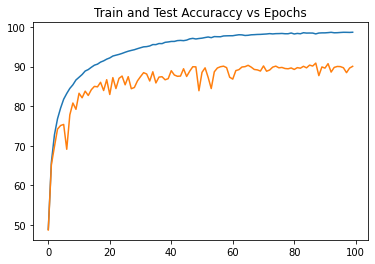

In [28]:
import matplotlib.pyplot as plt

#train plot
plt.plot(range(100), train_accs, color ='tab:blue') 
#test plot
plt.plot(range(100), test_accs, color ='tab:orange') 
  
plt.title('Train and Test Accuraccy vs Epochs') 
    
# display the plot 
plt.show()

In [29]:
# # Load checkpoint to test

checkpoint = torch.load('./checkpoint/ckpt.pth')
net.load_state_dict(checkpoint['net'])
best_acc = checkpoint['acc']
epoch = checkpoint['epoch']

In [32]:
print(f"Best Accuracy: {best_acc} at epoch: {epoch}")

Best Accuracy: 90.89 at epoch: 87
